In [8]:
#Ens connectem a la GPU
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [9]:
#Lliberies utilitzades
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dense
from tensorflow.keras.layers import Input, UpSampling2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
from tqdm import tqdm
import nibabel as nib
import cv2
import numpy as np
from sklearn.model_selection import KFold
from skimage.transform import rotate

/home/tfg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tfg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tfg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tfg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarnin

In [11]:
path = "HGG/HGG/"

In [20]:
#Funció per llegir les imatges de la base de dades
def load_data(path,mida):
  my_dir = sorted(os.listdir(path))
  flair=[]
  data = []
  gt = []
  seg_final=[]
  i=1
  for p in tqdm(my_dir): 
    if(p.startswith('Brats18')):
        #print(p)
        data_list = sorted(os.listdir(path+p))       
    
        seg = nib.load(path + p + '/'+ data_list[1]).get_fdata()
        seg=seg[40:200,30:220,:]
        seg=cv2.resize(seg,(240,240))
        seg_1=np.expand_dims(np.flip(seg,1),axis=0)
        seg_2=np.expand_dims(rotate(seg,angle=45),axis=0)
        seg=np.expand_dims(seg,axis=0)
        seg_final=np.concatenate((seg,seg_1,seg_2),axis=0)
        seg_final=np.transpose(seg_final,(1,2,0,3))
        seg_final=seg_final.reshape([240,240,-1])
        
        flair = nib.load(path + p + '/'+ data_list[0]).get_fdata()
        flair=flair[40:200,30:220,:]
        flair=cv2.resize(flair,(240,240))
        flair_1=np.expand_dims(np.flip(flair,1),axis=0)
        flair_2=np.expand_dims(rotate(flair,angle=45),axis=0)
        flair=np.expand_dims(flair,axis=0)
        flair_final=np.concatenate((flair,flair_1,flair_2),axis=0)
        flair_final=np.transpose(flair_final,(1,2,0,3))
        flair_final=flair_final.reshape([240,240,-1])
        
        t2 = nib.load(path + p + '/'+ data_list[4]).get_fdata()
        t2=t2[40:200,30:220,:]
        t2=cv2.resize(t2,(240,240))
        t2_1=np.expand_dims(np.flip(t2,1),axis=0)
        t2_2=np.expand_dims(rotate(t2,angle=45),axis=0)
        t2=np.expand_dims(t2,axis=0)
        t2_final=np.concatenate((t2,t2_1,t2_2),axis=0)
        t2_final=np.transpose(t2_final,(1,2,0,3))
        t2_final=t2_final.reshape([240,240,-1])
    
        data.append([flair_final,t2_final])
        gt.append(seg_final)
        if i>=mida:
          break
        else:
          i=i+1
  data = np.asarray(data,dtype=np.float16)
  gt = np.asarray(gt,dtype=np.uint8)
  return data,gt,flair

In [21]:
nombre_mostres=285

In [22]:
data1,gt1,flair = load_data(path,nombre_mostres)   #dividing HGG in three parts i.e. 210 into three sets of 70 

100%|██████████| 59/59 [02:09<00:00,  2.20s/it]


In [ ]:
#Modifiquem la forma dels vectors
data = np.transpose(data1,(0,4,2,3,1))
gt1=np.swapaxes(gt1,1,3)
gt1=np.swapaxes(gt1,2,3)
data = data.reshape([-1,240,240,2])
gt_final = gt1.reshape([-1,240,240,1])

In [ ]:
#Canviem els valors del vector gt_final
gt_final[np.where(gt!=0)]=1

In [ ]:
#Estructura de la U-NET
def unet():
    
    inputs = Input((240 , 240 , 2))
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(batch3)
    
    conv4 = Conv2D(512,3, activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(batch4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization()(conv5)
    
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same', activation='relu') (batch5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same') (up6)
    batch6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512,3, activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization()(conv6)
    
    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same', activation='relu') (batch6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256,3, activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256,3, activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization()(conv7)
    
    up8 = Conv2DTranspose(128,2, strides=(2, 2), padding='same', activation='relu') (batch7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128,3, activation='relu', padding='same') (up8)
    batch8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128,3, activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64,2, strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1,1,activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')

    return model

In [ ]:
#Dividim la base de dades en train i test
nombre_mostres=nombre_mostres*3
percentatge=abs(nombre_mostres*0.8)
#Train
input_train=data[0:int(percentatge*155),:,:,:]
target_train=gt_final[0:int(percentatge*155),:,:]
#Test
input_test=data[int(percentatge*155):,:,:,:]
target_test=gt_final[int(percentatge*155):,:,:,:]


In [19]:
#Funcions que calculen el dice
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

def mean_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    batch_size = y_true.shape[0]
    mean_dice_channel = 0.
    vector_dice=[]
    compt=1
    total_dice=[]
    for i in range(batch_size):
        if compt==155:
                vector_dice.append(dice_coef(y_true[i, :, :, 0], y_pred_bin[i, :, :,0]))
                total_dice.append(np.mean(vector_dice))
                vector_dice=[]
                compt=1
        else:
                vector_dice.append(dice_coef(y_true[i, :, :, 0], y_pred_bin[i, :, :,0]))
                compt=compt+1
    return total_dice

In [20]:
num_folds=5
inputs = input_train
targets =target_train
kfold = KFold(n_splits=num_folds, shuffle=True,random_state=100)
fold_no=1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
84816/84816 [==============================] - 2749s 32ms/step - loss: 0.4891
Epoch 2/20
84816/84816 [==============================] - 2741s 32ms/step - loss: 0.0927
Epoch 3/20
84816/84816 [==============================] - 2741s 32ms/step - loss: 0.0748
Epoch 4/20
84816/84816 [==============================] - 2742s 32ms/step - loss: 0.0630
Epoch 5/20
84816/84816 [==============================] - 2740s 32ms/step - loss: 0.0551
Epoch 6/20
84816/84816 [==============================] - 2743s 32ms/step - loss: 0.0489
Epoch 7/20
84816/84816 [==============================] - 2743s 32ms/step - loss: 0.0441
Epoch 8/20
84816/84816 [==============================] - 2743s 32ms/step - loss: 0.0405
Epoch 9/20
84816/84816 [==============================] - 2743s 32ms/step - loss: 0.0376
Epoch 10/20
84816/84816 [==============================] - 2743s 32ms/step - loss: 0.0354
Epoch 11/20


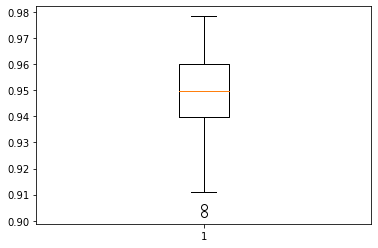

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/20
84816/84816 [==============================] - 2751s 32ms/step - loss: 0.4980
Epoch 2/20
84816/84816 [==============================] - 2746s 32ms/step - loss: 0.0956
Epoch 3/20
84816/84816 [==============================] - 2746s 32ms/step - loss: 0.0801
Epoch 4/20
84816/84816 [==============================] - 2745s 32ms/step - loss: 0.0681
Epoch 5/20
84816/84816 [==============================] - 2746s 32ms/step - loss: 0.0611
Epoch 6/20
84816/84816 [==============================] - 2745s 32ms/step - loss: 0.0543
Epoch 7/20
84816/84816 [==============================] - 2746s 32ms/step - loss: 0.0493
Epoch 8/20
84816/84816 [==============================] - 2746s 32ms/step - loss: 0.0451
Epoch 9/20
84816/84816 [==============================] - 2744s 32ms/step - loss: 0.0421
Epoch 10/20
84816/84816 [==============================] - 2744s 32ms/step - loss: 0.0393
Epoch 11/20


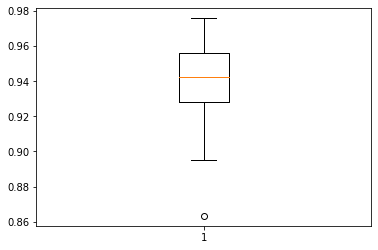

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/20
84816/84816 [==============================] - 2762s 33ms/step - loss: 0.5227
Epoch 2/20
84816/84816 [==============================] - 2755s 32ms/step - loss: 0.0942
Epoch 3/20
84816/84816 [==============================] - 2755s 32ms/step - loss: 0.0763
Epoch 4/20
84816/84816 [==============================] - 2756s 32ms/step - loss: 0.0658
Epoch 5/20
84816/84816 [==============================] - 2756s 32ms/step - loss: 0.0576
Epoch 6/20
84816/84816 [==============================] - 2755s 32ms/step - loss: 0.0515
Epoch 7/20
84816/84816 [==============================] - 2756s 32ms/step - loss: 0.0463
Epoch 8/20
84816/84816 [==============================] - 2756s 32ms/step - loss: 0.0425
Epoch 9/20
84816/84816 [==============================] - 2756s 32ms/step - loss: 0.0391
Epoch 10/20
84816/84816 [==============================] - 2755s 32ms/step - loss: 0.0366
Epoch 11/20


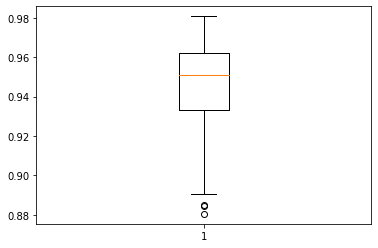

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/20
84816/84816 [==============================] - 2769s 33ms/step - loss: 0.5181
Epoch 2/20
84816/84816 [==============================] - 2760s 33ms/step - loss: 0.0967
Epoch 3/20
84816/84816 [==============================] - 2756s 32ms/step - loss: 0.0772
Epoch 4/20
84816/84816 [==============================] - 2756s 32ms/step - loss: 0.0656
Epoch 5/20
84816/84816 [==============================] - 2755s 32ms/step - loss: 0.0575
Epoch 6/20
84816/84816 [==============================] - 2754s 32ms/step - loss: 0.0514
Epoch 7/20
84816/84816 [==============================] - 2755s 32ms/step - loss: 0.0466
Epoch 8/20
84816/84816 [==============================] - 2756s 32ms/step - loss: 0.0427
Epoch 9/20
84816/84816 [==============================] - 2756s 32ms/step - loss: 0.0397
Epoch 10/20
84816/84816 [==============================] - 2754s 32ms/step - loss: 0.0372
Epoch 11/20


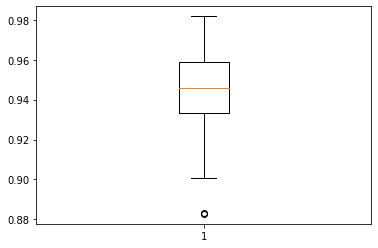

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/20
84816/84816 [==============================] - 2773s 33ms/step - loss: 0.5047
Epoch 2/20
84816/84816 [==============================] - 2763s 33ms/step - loss: 0.0954
Epoch 3/20
84816/84816 [==============================] - 2761s 33ms/step - loss: 0.0764
Epoch 4/20
84816/84816 [==============================] - 2762s 33ms/step - loss: 0.0649
Epoch 5/20
84816/84816 [==============================] - 2764s 33ms/step - loss: 0.0566
Epoch 6/20
84816/84816 [==============================] - 2764s 33ms/step - loss: 0.0502
Epoch 7/20
84816/84816 [==============================] - 2764s 33ms/step - loss: 0.0454
Epoch 8/20
84816/84816 [==============================] - 2764s 33ms/step - loss: 0.0418
Epoch 9/20
84816/84816 [==============================] - 2764s 33ms/step - loss: 0.0386
Epoch 10/20
84816/84816 [==============================] - 2764s 33ms/step - loss: 0.0362
Epoch 11/20


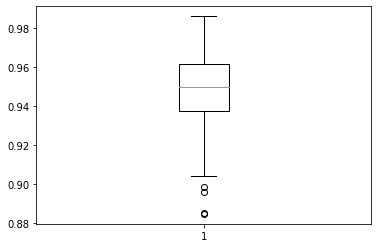

In [25]:
#Entrenem els models
loss_per_fold=[]
vec_models=[]
scores_dice_total=[]
for train, test in kfold.split(inputs, targets):
    model = unet()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],batch_size=8,epochs=20)
    vec_models.append(model)
    
    #Predim el model
    prediccio=model.predict(inputs[test])
    dades=inputs[test]
    dades[np.where(dades>0)]=1
    prediccio=prediccio*dades
    prediccio[np.where(prediccio<0.5)]=0
    prediccio[np.where(prediccio>=0.5)]=1
    
    #Calculem dice del model corresponent
    score=mean_dice_coef(prediccio,targets[test])
    
    #Calculem loss del model corresponent
    scores_lose = model.evaluate(inputs[test], targets[test], verbose=0)
    
    #Mostrem els resultats
    scores_dice=np.mean(score)
    dice_coeficient="['dice_coef']"
    print(f'Score for fold {fold_no}: {model.metrics_names} of {scores_lose}%')
    print(f'Score for fold {fold_no}: {dice_coeficient} of {scores_dice}%')
    
    #Creem boxplot
    plt.boxplot(score)
    plt.show()
    scores_dice_total.append(score)
    score=[]
    prediccio=[]
    score_dice=0
    loss_per_fold.append(scores_lose)
    fold_no = fold_no + 1


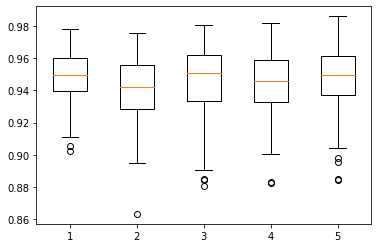

In [26]:
plt.boxplot(scores_dice_total)
plt.show()

In [27]:
vec_models[0].save('#3.1#SB_+BC_DA_5_fold_50_epochs.h5')
vec_models[1].save('#3.2#SB_+BC_DA_5_fold_50_epochs.h5')
vec_models[2].save('#3.3#SB_+BC_DA_5_fold_50_epochs.h5')
vec_models[3].save('#3.4#SB_+BC_DA_5_fold_50_epochs.h5')
vec_models[4].save('#3.5#SB_+BC_DA_5_fold_50_epochs.h5')

# AGAFEM EL MAXIM DELS 5 MODELS

In [ ]:
Y_pre1=vec_models[0].predict(input_test)
Y_pre2=vec_models[1].predict(input_test)
Y_pre3=vec_models[2].predict(input_test)
Y_pre4=vec_models[3].predict(input_test)
Y_pre5=vec_models[4].predict(input_test)

In [ ]:
#Creem un model amb el valor del píxel més gran de tots els 5 models
Y_pre_total_maxim=np.maximum(Y_pre1,Y_pre2)
Y_pre_total_maxim=np.maximum(Y_pre_total_maxim,Y_pre3)
Y_pre_total_maxim=np.maximum(Y_pre_total_maxim,Y_pre4)
Y_pre_total_maxim=np.maximum(Y_pre_total_maxim,Y_pre5)

Y_pre_total_maxim[np.where(Y_pre_total_maxim<0.5)]=0
Y_pre_total_maxim[np.where(Y_pre_total_maxim>=0.5)]=1

input_test=np.array(input_test,copy=True)
input_test2=input_test.copy()
input_test2[np.where(input_test2>0)]=1
Y_pre_total_maxim=Y_pre_total_maxim*input_test2

#Calculem accuracy
dades=mean_dice_coef(target_test, Y_pre_total_maxim)
print(f'Dice maxim dels 5 models: {np.mean(dades)}%')
plt.boxplot(dades)

In [ ]:
for i in range(80,90):
  print('input_test '+ str(i))
  plt.imshow(input_test[i,:,:,0])
  plt.show()
  plt.imshow(Y_pre_total_maxim[i,:,:,0])
  plt.show()
  plt.imshow(target_test[i,:,:,0])
  plt.show()

# AGAFEM LA MITJANA DELS 5 MODELS

In [ ]:
#Creem un model amb la mitjana dels valors dels píxels dels 5 models
Y_pre_total_mitjana=Y_pre1+Y_pre2+Y_pre3+Y_pre4+Y_pre5
Y_pre_total_mitjana=Y_pre_total_mitjana/5

Y_pre_total_mitjana[np.where(Y_pre_total_mitjana<0.5)]=0
Y_pre_total_mitjana[np.where(Y_pre_total_mitjana>=0.5)]=1
Y_pre_total_mitjana=Y_pre_total_mitjana*input_test2

#Calculem accuracy
dades=mean_dice_coef(target_test, Y_pre_total_mitjana)
print(f'Mitjana dels 5 models: {np.mean(dades)}%')
plt.boxplot(dades)

In [ ]:
for i in range(80,90):
  print('input_test '+ str(i))
  plt.imshow(input_test[i,:,:,0])
  plt.show()
  plt.imshow(Y_pre_total_mitjana[i,:,:,0])
  plt.show()
  plt.imshow(target_test[i,:,:,0])
  plt.show()

# AGAFEM EL MODEL AMB LA LOSS MÉS BAIXA

In [ ]:
#Ens quedem amb el model amb la loss més baixa
index_lowest_loss=np.where(loss_per_fold==np.min(loss_per_fold))
index_lowest_loss=np.asarray(index_lowest_loss)
np.savetxt('#3.6# index.txt',index_lowest_loss)
valor=int(index_lowest_loss[0])
model_lowest_low=vec_models[valor]

Y_pre_lowest_low=model_lowest_low.predict(input_test)
Y_pre_lowest_low[np.where(Y_pre_lowest_low<0.5)]=0
Y_pre_lowest_low[np.where(Y_pre_lowest_low>=0.5)]=1
Y_pre_lowest_low=Y_pre_lowest_low*input_test2

#Calculem dice
dades=mean_dice_coef(target_test, Y_pre_lowest_low)
print(f'Dice loss més petita: {np.mean(dades)}%')
plt.boxplot(dades)

In [ ]:
for i in range(80,90):
  print('input_test '+ str(i))
  plt.imshow(input_test[i,:,:,0])
  plt.show()
  plt.imshow(Y_pre_lowest_low[i,:,:,0])
  plt.show()
  plt.imshow(target_test[i,:,:,0])
  plt.show()

# Mirem el dice de tots els models amb les imatges de test

In [ ]:
#Mirem dice dels 5 models per separat
dades_totals=[]
Y_pre1[np.where(Y_pre1<0.5)]=0
Y_pre1[np.where(Y_pre1>=0.5)]=1
Y_pre1=Y_pre1*input_test2
dades1=mean_dice_coef(target_test, Y_pre1)
print(f'Dice model 1: {np.mean(dades1)}%')
dades_totals.append(dades1)

Y_pre2[np.where(Y_pre2<0.5)]=0
Y_pre2[np.where(Y_pre2>=0.5)]=1
Y_pre2=Y_pre2*input_test2
dades2=mean_dice_coef(target_test, Y_pre2)
print(f'Dice model 2: {np.mean(dades2)}%')
dades_totals.append(dades2)

Y_pre3[np.where(Y_pre3<0.5)]=0
Y_pre3[np.where(Y_pre3>=0.5)]=1
Y_pre3=Y_pre3*input_test2
dades3=mean_dice_coef(target_test, Y_pre3)
print(f'Dice model 3: {np.mean(dades3)}%')
dades_totals.append(dades3)

Y_pre4[np.where(Y_pre4<0.5)]=0
Y_pre4[np.where(Y_pre4>=0.5)]=1
Y_pre4=Y_pre4*input_test2
dades4=mean_dice_coef(target_test, Y_pre4)
print(f'Dice model 4: {np.mean(dades4)}%')
dades_totals.append(dades4)

Y_pre5[np.where(Y_pre5<0.5)]=0
Y_pre5[np.where(Y_pre5>=0.5)]=1
Y_pre5=Y_pre5*input_test2
dades5=mean_dice_coef(target_test, Y_pre5)
print(f'Dice model 5: {np.mean(dades5)}%')
dades_totals.append(dades5)

#BOXPLOT
plt.boxplot(dades_totals)